In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from cxutils import tableau20, to_histogram, plot_hist

In [2]:
usfd = pd.read_pickle('usfd.pickle')[['source', 'MaxShare']]
usfd_onehot = pd.read_pickle('usfd_onehot.pickle')[['source','fare_spread']]

# I Problem Definition
The task at hand is 
 * to predict the share of tickets bought in the highest fare bucket
 * using a model trained with data from the US air fare market in the period 1996-2010
 * tested against identical data for the US air fare market in the period 2011-2014
 * and to use the model to comment of air fare strategy and LCC pricing in the US
## I. 1. Requested Deliverables
 The deliverables are requested as follows:
 * A unified data set consisting of a concatenation of historical data, merged with distance information and airline type information from different data sources
 * Two kinds of predictive models (Regression & Random Forest) predicting a target variable, as well as an explanation of the models
 * A use case for the model in the context of airline pricing strategy
 * A statement on whether or not LCCs are selling their tickets for overall lower prices than Legacy carriers
 
In the context of the first two deliverables, several uncertainties existed which could not be clarified as this problem had to be evaluated over the weekend. In the following I will list the assumptions made and caveats taken to address these problems

### I. 1. a) Missing distance information
The provided file `2011_2014_Markets.xlsx` was supposed to contain the distance information for all relevant markets. However, various routes were missing (e.g., Albuquerque to El Paso). In these cases, I imputed the values using the vincenty distance between the latitude/longitute coordinates of the respective cities, as received from Google Maps. This applied to nearly 40% of all routes
### I. 1. b) Missing airline type information
The provided file `AirlineType.xlsx` did not contain mappings for all airlines in the historic data. I manually imputed values for Reno Airlines, Horizon Air and TWA. 

### I. 2. a) What is a feature, what is being predicted?
The problem instructions request to _Construct and estimate a demand model to predict the % of high fare passengers per city pair and airline_. However, the instructions suggest features like the average fare, i.e., information that is not intrinsic to route and airline per se. I assume that this implies that all input columns in the data sheet may be used as features, and will be provided when makeing a prediction. 
### I. 2. b) Model type 'Regression'
The instruction ask for one _Regression_ and one _Random Forest_ model. This is rather ambiguous - obviously, since the output variable is continuous, all models will be regression models (e.g., the random forest model will be a RandomForestRegressor). I assume the intent is to request a linear model
### I. 2. c) Different routes for different times
Even when disregarding airlines, it turns out that some routes only have information for some time periods, but not for others. Clearly, when looking at, say Albuquerque to Dallas in one year and then comparing it to, say, San Francisco to Portland in another, the comparison might not be all that helpful. 
### I. 2. d) Very strong time sensitivity of the predicted variable
The variable that is being predicted has an extremely strong direct dependence on time. This is not based on seasonal effects, as can be seen in the figure below, which plots an histogram of high fare shares in each of the four source files, averaging 4/5 years each:

0.7123473541383989 4


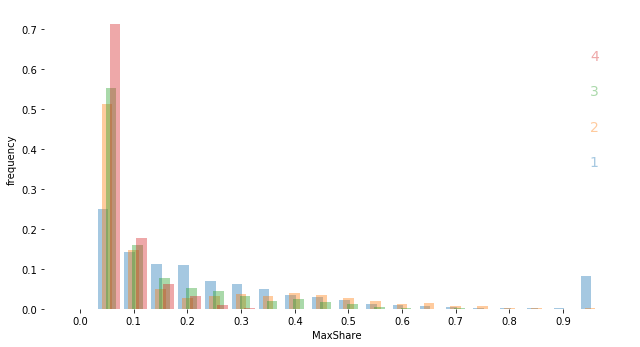

In [3]:
hist_data, bins = to_histogram(usfd, 'MaxShare', 0, 1, 20, 'source')
plot_hist(hist_data, bins)

As is visible here, the distribution of the target variable changes massively over time, to the point that it becomes questionable why one would actually want to predict it. In any case, a pretty accurate model could be built by simply postulating that `MaxShare = 0.07`. While it cannot be ruled out that there are time-independent features in the data set that would explain this decay, it seems at the very least unlikely, since major revenue and cost drivers (economic growth and kerosene costs) are not provided with the data. 
Given that this time dependence might have a major impact of prediction results, I have decided to use a two-tiered approach for model evaluation:
 1. Unify all historic data, randomly select records with an 80/20 split for training/holdout sample, and evaluate the general model fitness on this data
 2. Split training/testing data by year cohorts in 2010 as requested, and evaluate model performance here

# II Deliverables
## II 1. Unified Data Source
A csv of the unified data source can be found here: http://54.254.210.117:8888/view/cx/usfd_w_distance_type_ok.pickle
The pickle can be loaded with the commands
```
import pandas as pd
df = pd.read_pickle('usfd_w_distance_type_ok.pickle')
```

## II 2. Model
### II 2. a) Linear Regression Model
A system of this level of complexity likely has nonlinear effects, which cannot be grasped by a simple linear regression model. This can partly be circumvented by creating new features as higher order polynomials of the original features, e.g., instead of using only `AvgFare` and `is_LCC`, we also use `AvgFare * is_LCC`. A model that follows this approach can be found here: 
Yet, for the best feature set, we merely achieve an R2 of ~ 0.81 on the randomly chosen test data, and ~.78 for the time split test data. Furthermore, the model predicts negative values. This model is unsuitable. 
### II 2. b) Random Forest Regression Model
Decision trees can piecewise approximate any function, and are reasonably well suited to nonlinear problems. An evaluation of Random Forest Regression models for the random chosen test data can be found here: 
And for the time split here:
The results are sensible - we achieve a training-R2 of approximately .96 on both data splits, and a test-R2 of nearly .93 on the randomly selected test sample. The test results on the time-split data sets are however unusable, showing that the model cannot be applied out of time. 
### II 2. c) Other Models - Gradient Boosted Trees
Gradient boosted trees are commonly performing superior to normal random forests. While for standard random forests the 'noise' term simply decays with the number of trees, it is actively 'targeted' in the case of gradient boosted trees. The evaluation can be found here for the random chosen test data: 
And for the time split here:
For the randomly chosen split, the model clearly outperforms random forests, to the point that it perfectly (over-) fits the training sample. But even for the test set, the R2 increases by 0.01 (which is no mean feat once you're that close to 1). However, as before, it is hopeless in case of the time split. 
### II 2. d) Feature Analysis
I analysed features in three sets 
* original features provided in the data set
* features that can be directly derived within the data set (e.g., fare spread)
* features that require human input or external data (e.g., flag transcontinental flights)
As it turned out, the explanatory power rests overwhelmingly within the fare spread, i.e., the relative difference between the minimum and the maximum fare. This can easily be rationalised: Assuming that fare buckets are somehwat evenly spread, a wider range of fares obviously corresponds to a lower number of people in the topmost fare bucket. As a consequence, the tendency of airlines to use ever-increasing granularity in pricing means that the number of fare buckets likely went up, and the number of passengers in each bucket likely went down. Overall, we arrive at the same conclusion we had before - `MaxShare` is a really odd modeling target....
For further illustration, the 

0.35404255319148936 4


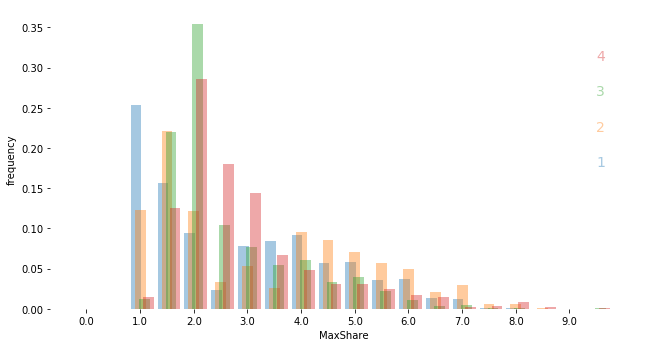

In [7]:
hist_data, bins = to_histogram(usfd_onehot, 'fare_spread', 0, 10, 20, 'source')
plot_hist(hist_data, bins)

## II 3. Usefulness for Pricing Strategy
I'm sorry to disappoint, but the quantity, as I understand it, is likely not terribly useful for pricing alone. As is shown in the above plot, the spread between cheapest and most expensive fares is ever widening. This is particularly noticeable since we are talking about domestic US flight, where the premium cabin (domestic first) is only comparable to a CX premium economy. However, a more detailed analysis that would predict the share of passengers willing to pay x% above the average fare could be very useful in deciding price elasticity. 

II 4. Legacy vs LCC pricing